# Dog Breed Classification with DenseNet121

This notebook presents a comparative study of different training strategies for fine-grained dog breed classification.
We evaluate DenseNet121 trained from scratch using single-phase and two-phase training, and compare them against a transfer learning baseline using ImageNet-pretrained weights.

The focus is on understanding overfitting behavior in low-data regimes and assessing the effectiveness of staged training.


## Problem Statement

Dog breed classification is a fine-grained visual recognition task where classes share strong visual similarities.
This makes the problem particularly challenging under limited data availability.

## Dataset

We use a curated subset of the Stanford Dogs dataset.
Only breeds with at least 200 images were retained, resulting in:
- 15 dog breeds
- ~3,000 total images

The dataset is split into training and validation sets only (no test split), as the focus is on model comparison and generalization behavior.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_b4a0201821866cb17a1bb01e884502a5"

In [ ]:
!mkdir -p ~/.kaggle
!python -c "import os, pathlib; t=os.environ.get('KAGGLE_API_TOKEN','').strip(); assert t.startswith('KGAT'); pathlib.Path.home().joinpath('.kaggle','access_token').write_text(t); print('OK: scritto ~/.kaggle/access_token')"
!chmod 600 ~/.kaggle/access_token

OK: scritto ~/.kaggle/access_token


In [ ]:

!pip -q install -U kagglehub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 9.4 MB/s eta 0:00:00


In [ ]:
import kagglehub
from pathlib import Path

dataset_path = Path(kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset"))
print("Dataset in:", dataset_path)

# trova automaticamente la cartella Images
images_dir = None
for p in dataset_path.rglob("Images"):
    if p.is_dir():
        images_dir = p
        break

print("Images dir:", images_dir)



100%|██████████| 750M/750M [00:07<00:00, 110MB/s] 

Extracting files...


Dataset in: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2
Images dir: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images


In [ ]:
print(dataset_path)
print(images_dir)

/root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2
/root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images


In [ ]:
%cd /content
!git clone https://github.com/AlessBenz/dog-classification-densenet.git
%cd dog-classification-densenet
!ls

/content
Cloning into 'dog-classification-densenet'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 38 (delta 12), reused 36 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 16.59 KiB | 1.84 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/dog-classification-densenet
configs  notebooks  README.md  requirements.txt  scripts  src


In [ ]:
!pip -q install -r requirements.txt

In [ ]:
from pathlib import Path
import shutil, json

images_dir = Path("/root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2/images/Images")
THR = 200

out_root = Path("filtered_dataset_thr200/images/Images")
if out_root.parent.parent.exists():
    shutil.rmtree(out_root.parent.parent)
out_root.mkdir(parents=True, exist_ok=True)

selected = []
for cls_dir in images_dir.iterdir():
    if cls_dir.is_dir():
        n = len(list(cls_dir.glob("*.jpg")))
        if n > THR:
            selected.append((cls_dir.name, n))

selected.sort(key=lambda x: x[1], reverse=True)
print("Selected classes:", len(selected))
print(selected)

Path("filtered_dataset_thr200/subset_manifest.json").write_text(
    json.dumps({"threshold": THR, "rule": f"> {THR}", "classes": selected}, indent=2)
)

for name, _ in selected:
    src = images_dir / name
    dst = out_root / name
    dst.mkdir(parents=True, exist_ok=True)
    for img in src.glob("*.jpg"):
        shutil.copy2(img, dst / img.name)

print("Done:", out_root)



Selected classes: 15
[('n02085936-Maltese_dog', 252), ('n02088094-Afghan_hound', 239), ('n02092002-Scottish_deerhound', 232), ('n02112018-Pomeranian', 219), ('n02090721-Irish_wolfhound', 218), ('n02107683-Bernese_mountain_dog', 218), ('n02111889-Samoyed', 218), ('n02086240-Shih-Tzu', 214), ('n02111500-Great_Pyrenees', 213), ('n02111129-Leonberg', 210), ('n02110806-basenji', 209), ('n02097474-Tibetan_terrier', 206), ('n02095889-Sealyham_terrier', 202), ('n02096051-Airedale', 202), ('n02108000-EntleBucher', 202)]
Done: filtered_dataset_thr200/images/Images


In [ ]:
import random, shutil
from pathlib import Path

SEED = 42
train_ratio = 0.8

src_root = Path("filtered_dataset_thr200/images/Images")
out_split = Path("data/split_thr200")
train_out = out_split/"train"
val_out = out_split/"val"

if out_split.exists():
    shutil.rmtree(out_split)
train_out.mkdir(parents=True, exist_ok=True)
val_out.mkdir(parents=True, exist_ok=True)

random.seed(SEED)

for cls_dir in src_root.iterdir():
    imgs = sorted(cls_dir.glob("*.jpg"))
    random.shuffle(imgs)
    k = int(len(imgs) * train_ratio)

    (train_out/cls_dir.name).mkdir(parents=True, exist_ok=True)
    (val_out/cls_dir.name).mkdir(parents=True, exist_ok=True)

    for p in imgs[:k]:
        shutil.copy2(p, train_out/cls_dir.name/p.name)
    for p in imgs[k:]:
        shutil.copy2(p, val_out/cls_dir.name/p.name)

print("Done split:", out_split)


Done split: data/split_thr200


## Model Architecture

All experiments use DenseNet121 as backbone.
A custom classification head is added on top of the convolutional features, consisting of:
- Fully connected layer
- ReLU activation
- Dropout
- Final classification layer

Training uses cross-entropy loss, Adam optimizer, and standard data augmentation.

## Training Strategies

### Scratch - Single Phase
The network is trained end-to-end from random initialization using a constant learning rate.

### Scratch - Two Phase (Staged Training)
Training is divided into two phases:
1. Full network training with a higher learning rate.
2. Partial freezing of early convolutional layers and reduced learning rate.

This strategy aims to stabilize learned representations and mitigate overfitting.

### Transfer Learning (ImageNet)
DenseNet121 is initialized with ImageNet-pretrained weights.
Only the last convolutional block and classifier are fine-tuned.


In [ ]:
!python -m src.train --data_dir data/split_thr200 --out_dir runs/scratch_1phase --epochs 300



/content/dog-classification-densenet/src/train.py:175: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(amp and device.type == "cuda"))
train:   0% 0/41 [00:00<?, ?it/s]/content/dog-classification-densenet/src/train.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[epoch 1/300] train acc=0.1278 val acc=0.1689 best=0.1689
[epoch 2/300] train acc=0.1945 val acc=0.2009 best=0.2009
[epoch 3/300] train acc=0.2133 val acc=0.1826 best=0.2009
[epoch 4/300] train acc=0.2484 val acc=0.2435 best=0.2435
[epoch 5/300] train acc=0.2745 val acc=0.2816 best=0.2816
[epoch 6/300] train acc=0.2830 val acc=0.2511 best=0.2816
[epoch 7/300] train acc=0.3092 val acc=0.3029 best=0.3029
[epoch 8/300] train acc=0.3131 val acc=0.3059 best=0.3059
[epoch 9/300] train acc=0.3562 val acc=0.3196 best=0.3196
[epo

In [ ]:

!python -m src.train \
  --data_dir data/split_thr200 \
  --out_dir runs/scratch_2phase \
  --epochs 300 \
  --no_test \
  --phase1_epochs 75 --phase2_epochs 225 \
  --freeze_first_n 2 --phase2_lr 5e-5



/content/dog-classification-densenet/src/train.py:175: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(amp and device.type == "cuda"))
train:   0% 0/41 [00:00<?, ?it/s]/content/dog-classification-densenet/src/train.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[epoch 1/300] train acc=0.1332 val acc=0.1872 best=0.1872
[epoch 2/300] train acc=0.1833 val acc=0.1979 best=0.1979
[epoch 3/300] train acc=0.2145 val acc=0.2588 best=0.2588
[epoch 4/300] train acc=0.2399 val acc=0.2314 best=0.2588
[epoch 5/300] train acc=0.2738 val acc=0.3166 best=0.3166
[epoch 6/300] train acc=0.2672 val acc=0.2740 best=0.3166
[epoch 7/300] train acc=0.2865 val acc=0.2892 best=0.3166
[epoch 8/300] train acc=0.3061 val acc=0.3516 best=0.3516
[epoch 9/300] train acc=0.3412 val acc=0.2009 best=0.3516
[epo

In [ ]:
!python -m src.train \
  --data_dir data/split_thr200 \
  --out_dir runs/imagenet_lastblock \
  --epochs 50 \
  --use_pretrained --fine_tune last_block \
  --lr 1e-4 \
  --no_test

/content/dog-classification-densenet/src/train.py:175: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(amp and device.type == "cuda"))
train:   0% 0/41 [00:00<?, ?it/s]/content/dog-classification-densenet/src/train.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[epoch 1/50] train acc=0.5356 val acc=0.8721 best=0.8721
[epoch 2/50] train acc=0.8406 val acc=0.9102 best=0.9102
[epoch 3/50] train acc=0.8860 val acc=0.9315 best=0.9315
[epoch 4/50] train acc=0.9118 val acc=0.9346 best=0.9346
[epoch 5/50] train acc=0.9245 val acc=0.9239 best=0.9346
[epoch 6/50] train acc=0.9299 val acc=0.9315 best=0.9346
[epoch 7/50] train acc=0.9434 val acc=0.9285 best=0.9346
[epoch 8/50] train acc=0.9511 val acc=0.9330 best=0.9346
[epoch 9/50] train acc=0.9638 val acc=0.9315 best=0.9346
[epoch 10/50]

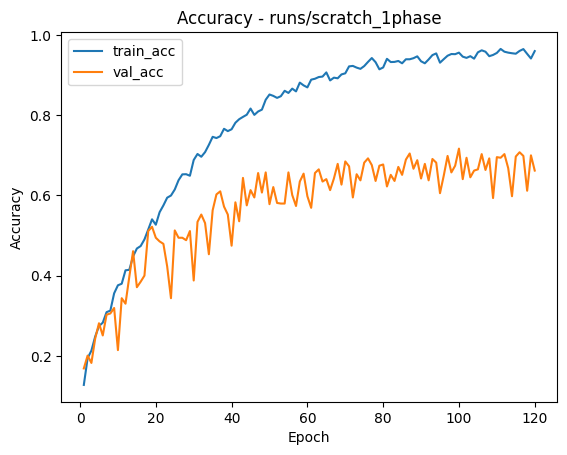

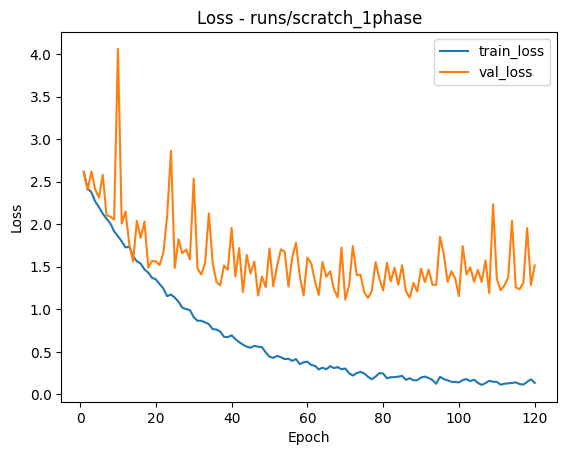

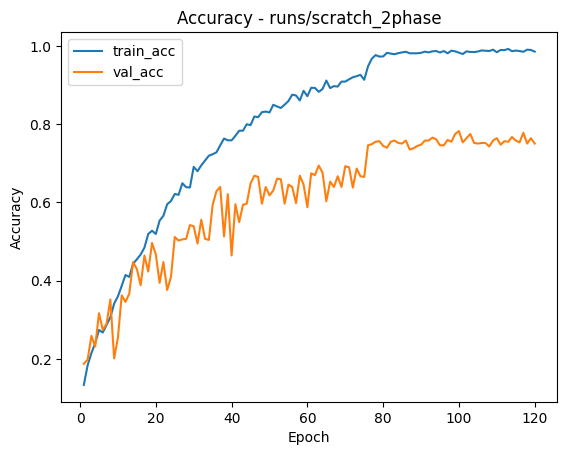

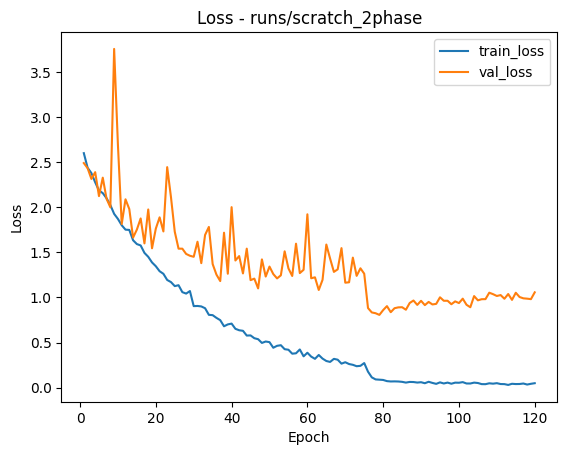

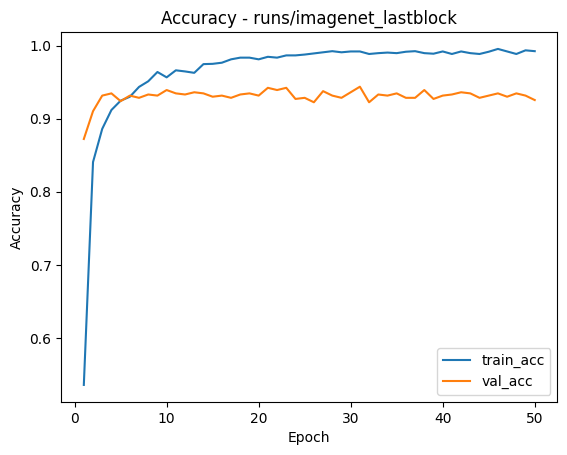

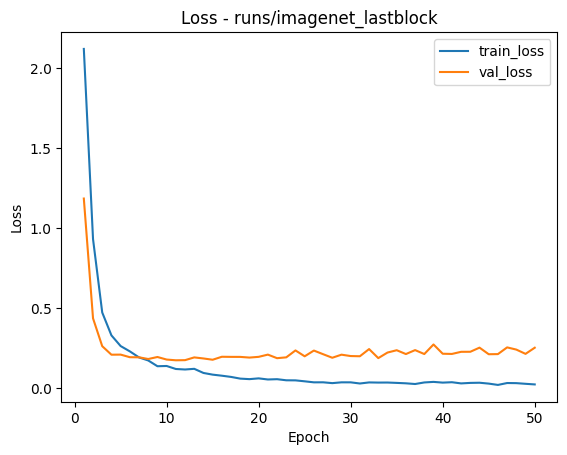

In [ ]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

def plot_run(run_dir: str):
    run_dir = Path(run_dir)
    hist_path = run_dir / "history.json"
    if not hist_path.exists():
        print(f"[SKIP] {run_dir}: history.json non trovato")
        return

    hist = json.loads(hist_path.read_text())
    epochs = [h["epoch"] + 1 for h in hist]
    tr_acc = [h["train_acc"] for h in hist]
    va_acc = [h["val_acc"] for h in hist]
    tr_loss = [h["train_loss"] for h in hist]
    va_loss = [h["val_loss"] for h in hist]

    # Accuracy plot
    plt.figure()
    plt.plot(epochs, tr_acc, label="train_acc")
    plt.plot(epochs, va_acc, label="val_acc")
    plt.title(f"Accuracy - {run_dir.as_posix()}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Loss plot
    plt.figure()
    plt.plot(epochs, tr_loss, label="train_loss")
    plt.plot(epochs, va_loss, label="val_loss")
    plt.title(f"Loss - {run_dir.as_posix()}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

runs = [
    "runs/scratch_1phase",
    "runs/scratch_2phase",
    "runs/imagenet_lastblock",
]
for r in runs:
    plot_run(r)


In [ ]:
import json
from pathlib import Path

def summarize_history(run_dir: str):
    run_dir = Path(run_dir)
    hist_path = run_dir / "history.json"
    if not hist_path.exists():
        return None

    hist = json.loads(hist_path.read_text())
    best_i = max(range(len(hist)), key=lambda i: hist[i]["val_acc"])
    best = hist[best_i]

    return {
        "run": run_dir.as_posix(),
        "epochs_ran": len(hist),
        "best_epoch": best["epoch"] + 1,
        "best_val_acc": float(best["val_acc"]),
        "train_acc_at_best": float(best["train_acc"]),
        "gap_train_minus_val": float(best["train_acc"] - best["val_acc"]),
        "val_loss_at_best": float(best["val_loss"]),
        "train_loss_at_best": float(best["train_loss"]),
    }

runs = [
    "runs/scratch_1phase",
    "runs/scratch_2phase",
    "runs/imagenet_lastblock",
]

summaries = []
for r in runs:
    s = summarize_history(r)
    if s is None:
        print(f"[SKIP] {r}: history.json non trovato")
    else:
        summaries.append(s)

for s in summaries:
    print(
        f"\n{s['run']}\n"
        f"  epochs_ran: {s['epochs_ran']}\n"
        f"  best_epoch: {s['best_epoch']}\n"
        f"  best_val_acc: {s['best_val_acc']:.4f}\n"
        f"  train_acc@best: {s['train_acc_at_best']:.4f}\n"
        f"  gap(train-val)@best: {s['gap_train_minus_val']:.4f}\n"
        f"  val_loss@best: {s['val_loss_at_best']:.4f}\n"
    )



runs/scratch_1phase
  epochs_ran: 120
  best_epoch: 100
  best_val_acc: 0.7169
  train_acc@best: 0.9561
  gap(train-val)@best: 0.2392
  val_loss@best: 1.1557


runs/scratch_2phase
  epochs_ran: 120
  best_epoch: 100
  best_val_acc: 0.7823
  train_acc@best: 0.9827
  gap(train-val)@best: 0.2003
  val_loss@best: 0.9378


runs/imagenet_lastblock
  epochs_ran: 50
  best_epoch: 31
  best_val_acc: 0.9437
  train_acc@best: 0.9919
  gap(train-val)@best: 0.0482
  val_loss@best: 0.1984



In [ ]:
import json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import balanced_accuracy_score, f1_score, log_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_state(run_dir: Path):
    ckpt = torch.load(run_dir / "checkpoints" / "best.pt", map_location="cpu")
    return ckpt["model_state"] if isinstance(ckpt, dict) and "model_state" in ckpt else ckpt

def get_norm_stats(run_dir: Path):
    p = run_dir / "data_stats.json"
    if p.exists():
        s = json.loads(p.read_text())
        return s["mean"], s["std"]
    return [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

def build_model_from_state(state: dict, num_classes: int):
    """
    Supporta:
    - DenseNet121 con classifier = Linear (key 'classifier.weight')
    - DenseNet121 con classifier = Sequential (keys 'classifier.0.weight' e 'classifier.3.weight' tipiche)
    """
    m = models.densenet121(weights=None)
    in_features = m.classifier.in_features

    if "classifier.weight" in state:
        # head semplice
        m.classifier = nn.Linear(in_features, num_classes)
        return m

    # prova a riconoscere la head Sequential
    # caso tipico: Linear(in_features->hidden) + ... + Linear(hidden->num_classes)
    if "classifier.0.weight" in state and "classifier.3.weight" in state:
        hidden_dim = state["classifier.0.weight"].shape[0]
        # dropout non è ricostruibile dai pesi: metto 0.0 (non influisce in eval)
        m.classifier = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.0),
            nn.Linear(hidden_dim, num_classes),
        )
        return m

    # fallback: se i nomi sono diversi, scegliamo un classifier linear “safe”
    # e carichiamo strict=False (così non crasha)
    m.classifier = nn.Linear(in_features, num_classes)
    return m

def eval_val(run_dir: str, data_dir: str, batch_size=64, num_workers=2):
    run_dir = Path(run_dir)
    data_dir = Path(data_dir)

    mean, std = get_norm_stats(run_dir)
    tfm = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    val_ds = datasets.ImageFolder(str(data_dir / "val"), transform=tfm)
    num_classes = len(val_ds.classes)

    state = load_state(run_dir)
    model = build_model_from_state(state, num_classes)
    model.to(device).eval()

    # strict=True se combacia; se hai fallback può servire strict=False
    try:
        model.load_state_dict(state, strict=True)
    except RuntimeError:
        model.load_state_dict(state, strict=False)

    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    y_true, y_pred, y_prob = [], [], []
    top5_ok, total = 0, 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)

            pred = probs.argmax(dim=1)
            top5 = probs.topk(5, dim=1).indices

            y_true.append(y.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
            y_prob.append(probs.cpu().numpy())

            top5_ok += (top5 == y.unsqueeze(1)).any(dim=1).sum().item()
            total += y.size(0)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_prob = np.concatenate(y_prob)

    return {
        "top5": top5_ok / total,
        "balanced_acc": float(balanced_accuracy_score(y_true, y_pred)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro")),
        "f1_weighted": float(f1_score(y_true, y_pred, average="weighted")),
        "val_logloss": float(log_loss(y_true, y_prob, labels=list(range(num_classes)))),
    }

runs = [
    ("runs/scratch_1phase", "data/split_thr200"),
    ("runs/scratch_2phase", "data/split_thr200"),
    ("runs/imagenet_lastblock", "data/split_thr200"),
]

for r, d in runs:
    h = summarize_history(r)
    if h is None:
        print(f"[SKIP] {r}: history.json non trovato")
        continue
    m = eval_val(r, d)
    print(
        f"\n{r}\n"
        f"  best_epoch={h['best_epoch']}  best_val_acc={h['best_val_acc']:.4f}  gap={h['gap_train_minus_val']:.4f}\n"
        f"  top5={m['top5']:.4f}  bal_acc={m['balanced_acc']:.4f}  f1_macro={m['f1_macro']:.4f}  "
        f"f1_w={m['f1_weighted']:.4f}  logloss={m['val_logloss']:.4f}"
    )



runs/scratch_1phase
  best_epoch=100  best_val_acc=0.7169  gap=0.2392
  top5=0.9589  bal_acc=0.7175  f1_macro=0.7204  f1_w=0.7194  logloss=1.1557

runs/scratch_2phase
  best_epoch=100  best_val_acc=0.7823  gap=0.2003
  top5=0.9619  bal_acc=0.7838  f1_macro=0.7824  f1_w=0.7811  logloss=0.9378

runs/imagenet_lastblock
  best_epoch=31  best_val_acc=0.9437  gap=0.0482
  top5=0.9985  bal_acc=0.9444  f1_macro=0.9441  f1_w=0.9436  logloss=0.1984


## Discussion

Training from scratch exhibits strong overfitting due to limited data availability.
The proposed two-phase training strategy reduces overfitting and improves validation accuracy by approximately 6.5 percentage points.

Transfer learning dramatically outperforms scratch training, highlighting the importance of pretrained representations in fine-grained classification tasks.

## Conclusion

This study shows that staged training can partially mitigate overfitting when training deep CNNs from scratch.
However, transfer learning remains the most effective approach under limited data regimes.
